In [48]:
import json
from fastdtw import fastdtw
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
import itertools

In [246]:
with open('tmp/cuysq_6000_preserve3b_learnedseenlongd.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetracelearned = json.load(f)['data'][1::]
    flattened = [j for i in statetracelearned[1:2] for j in i]

In [247]:
sensornames = ['S'+str(idx) for idx in range(16)]
run = 3
epoch=0
startday = epoch*30
periods = 8#in three hours 8 periods make a full day
duration =300#days
#
"""
run=2
startday = 39
periods = 8#in three hours 8 periods make a full day
duration =5#days
#"""
select = [startday*periods,(startday+duration)*periods]
traces = {}
for s in sensornames:
    traces[s] = np.asarray([i[s] for i in flattened])#[select[0]:select[1]]])

In [267]:
def extract_feature(t):
    is_active = lambda i:i[0]==0 and i[1]>0
    is_idle = lambda i:i[0]==1 and i[1]>0
    is_sleep = lambda i:i[0]==2 and i[1]>0
    is_dead = lambda i:i[1]==0
    counter = lambda data, f: len([i for i in data if f(i)])
    return [counter(t, f) for f in [is_active,is_idle,is_sleep,is_dead]]
def extract_timesensitive_feature(t):
    sorted_by_time = sorted(t, key=lambda i:i[3])
    grouped_by_time = itertools.groupby(sorted_by_time, key=lambda i:i[3])
    features_by_time = {k:extract_feature(list(v)) for k,v in grouped_by_time}
    keys = sorted(list(set([k for k in features_by_time])))
    return np.asarray(list(itertools.chain(*[features_by_time[k] for k in keys])))

extract_timesensitive_feature(traces['S1'])


array([222,   1,   3,  74,  57,   1,   4, 238,  28,   0,   4, 268, 198,
         0,  37,  65, 213,   1,  72,  14, 222,   1,  64,  13, 223,   2,
        59,  16, 246,   0,  14,  40])

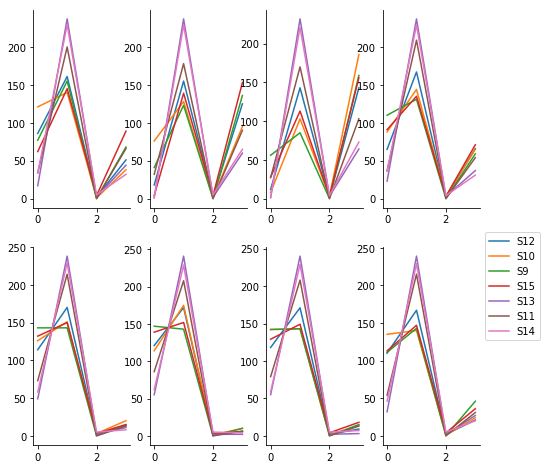

In [335]:
#delayed gratification nodes
fig, axarr = plt.subplots(2,4)
fig.set_size_inches(8,8)
for idx, ax in enumerate(itertools.chain(*axarr)):
    for s in ['S12','S10','S9','S15']+['S13','S11','S14']:
        feature = extract_timesensitive_feature(traces[s])
        #print(np.shape(feature), idx)
        ax.plot(feature[idx*4:idx*4+4], label=s)
        #ax.text(1,-10,str(idx))
ax.legend(bbox_to_anchor=((1,1.1)))
#ax.plot([0,4],[0,0])
sns.despine()
#more time idle than active is the central feature, 
#no major temporal difference, except a little more active time at midday

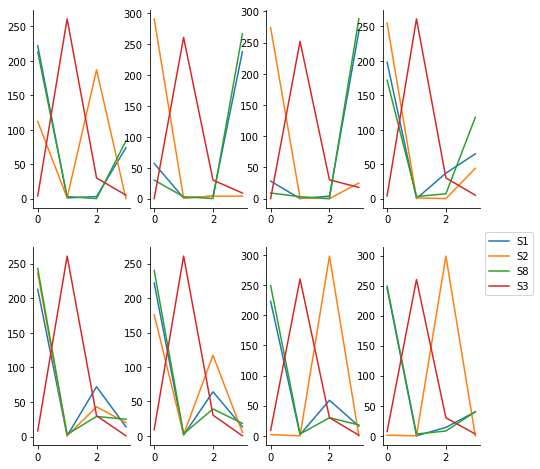

In [342]:
#delayed gratification nodes
fig, axarr = plt.subplots(2,4)
fig.set_size_inches(8,8)
for idx, ax in enumerate(itertools.chain(*axarr)):
    for s in ['S1','S2','S8','S3']:
        feature = extract_timesensitive_feature(traces[s])
        #print(np.shape(feature), idx)
        ax.plot(feature[idx*4:idx*4+4], label=s)
        #ax.text(1,-10,str(idx))
ax.legend(bbox_to_anchor=((1,1.1)))
#ax.plot([0,4],[0,0])
sns.despine()
#defining feature is non zero standby time,
#most commonly occuring in midday, allowing nightime activity

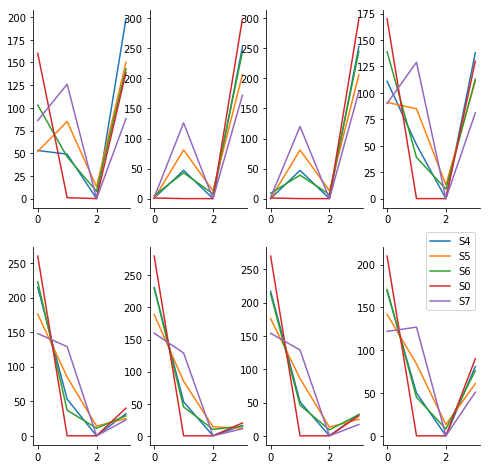

In [340]:
#worker nodes
fig, axarr = plt.subplots(2,4)
fig.set_size_inches(8,8)
for idx, ax in enumerate(itertools.chain(*axarr)):
    for s in ['S4','S5','S6','S0']+['S7']:
        feature = extract_timesensitive_feature(traces[s])
        #print(np.shape(feature), idx)
        ax.plot(feature[idx*4:idx*4+4], label=s)
        #ax.text(1,-10,str(idx))
ax.legend(bbox_to_anchor=((1,1.1)))
#ax.plot([0,4],[0,0])
sns.despine()
#defining feature is the combination of high proportion active, and almost no time standby
#node 7 is a bit between worker and idler, node 0 is a pure worker

In [296]:
data = np.zeros((16,16))
for x,y in itertools.product(sensornames, repeat=2):#, repeat=2):
    idx1 = sensornames.index(x)
    idx2 = sensornames.index(y)
    d = distance.euclidean(extract_timesensitive_feature(traces[x]), extract_timesensitive_feature(traces[y]))
    data[idx1,idx2] = d
#distance, path = fastdtw(traces['S1'], traces['S1'])#, dist=euclidean)

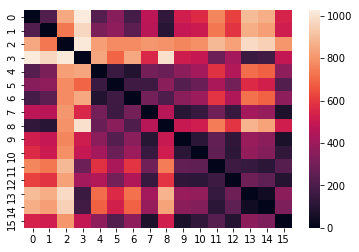

In [297]:
sns.heatmap(data)